<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 7 - Modelos de Ensambles - Xgboost</h3>
    <h3>Ejercicio 1_Sincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelos Ensambles**   

Los modelos de Gradient Boosting, como XGBoost y LightGBM, han demostrado su eficacia en una amplia gama de aplicaciones de aprendizaje automático, desde clasificación hasta regresión. Sin embargo, una de las áreas más desafiantes y emocionantes en las que estos algoritmos han encontrado aplicabilidad es en la predicción de series de tiempo. La adaptación de estos modelos al dominio de series temporales es esencial, ya que las características únicas de este tipo de datos, como la dependencia temporal y la estacionalidad, requieren un enfoque especializado. En esta introducción, exploraremos cómo se aplican y adaptan los modelos de aumento de gradiente para abordar problemas de predicción de series de tiempo.

¿Qué es el Boosting? Boosting es una técnica conjunta de aprendizaje automático que combina múltiples modelos débiles (weak models) en un único modelo fuerte. En Boosting, cada modelo aprende de los errores del modelo anterior, lo que da como resultado un modelo mejor en general. El objetivo es mejorar la precisión de un modelo reduciendo la varianza y el sesgo en los datos. Boosting es una técnica popular para resolver problemas de clasificación y regresión.

Las principales diferencias de LightGBM frente a XGBoost es su estrategia de crecimiento de árboles en forma de hojas, su técnica exclusiva de agrupación de funciones y su menor consumo de memoria.


**Objetivo del Ejercicio**: Elaborar un modelo de predicción del Consumo de energía por hora utilizando un modelo Xgboost.  
Dataset: Más de 10 años de datos de consumo de energía por hora de una organización de transmisión regional (RTO) en los Estados Unidos, en megavatios.  

Queremos predecir el consumo futuro.  

Documentación: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

Fuente del ejercicio: https://www.youtube.com/watch?v=z3ZnOW-S550&t=59s

Fuente de los datos: https://www.pjm.com/

Carga de Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')
#plt.style.use('fivethirtyeight')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Carga y Procesamiento inicial del dataset

In [ ]:
URL= 'https://raw.githubusercontent.com/braiandrago/AST/main/consumo_2.csv'
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df['Datetime'].dtype #otra forma de verificar

dtype('O')

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%Y.%m.%d %H:%M:%S')

In [ ]:
df = df.set_index('Datetime')
df.sort_index(inplace=True)
print(df.shape)
df.head()

(145366, 1)


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [ ]:
df.tail(5)

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


Los datos tienen uns frecuencia de registro cada 1 hora

**Visualizamos la serie:**

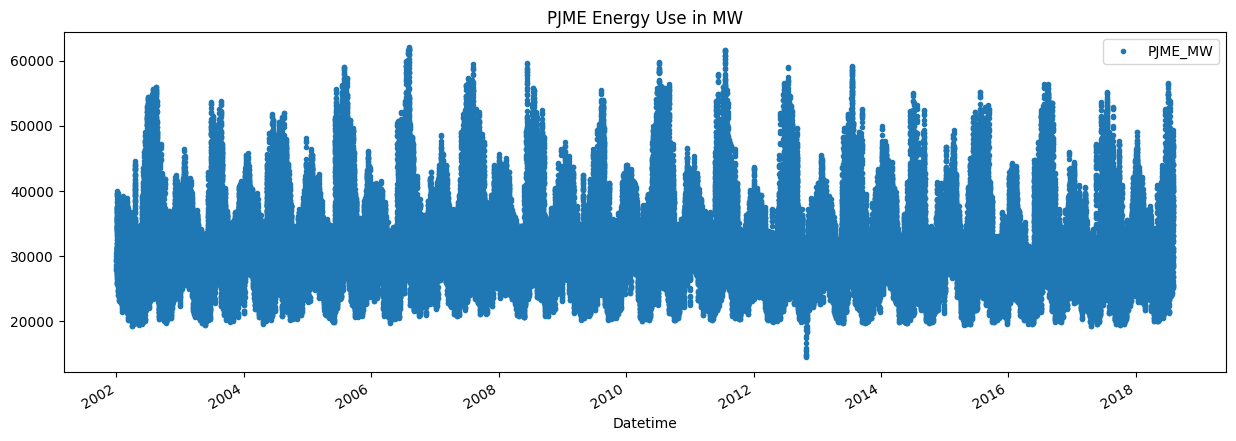

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Que observamos en la gráfica?

**Valores faltantes:**

In [ ]:
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna PJME_MW: 0


In [ ]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


**Análisis de Outliers**

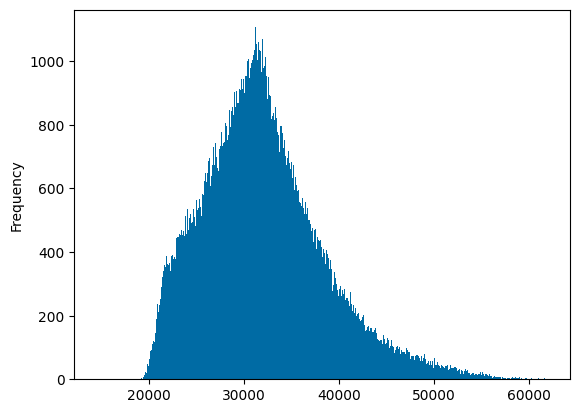

In [ ]:
df['PJME_MW'].plot(kind='hist', bins=500);

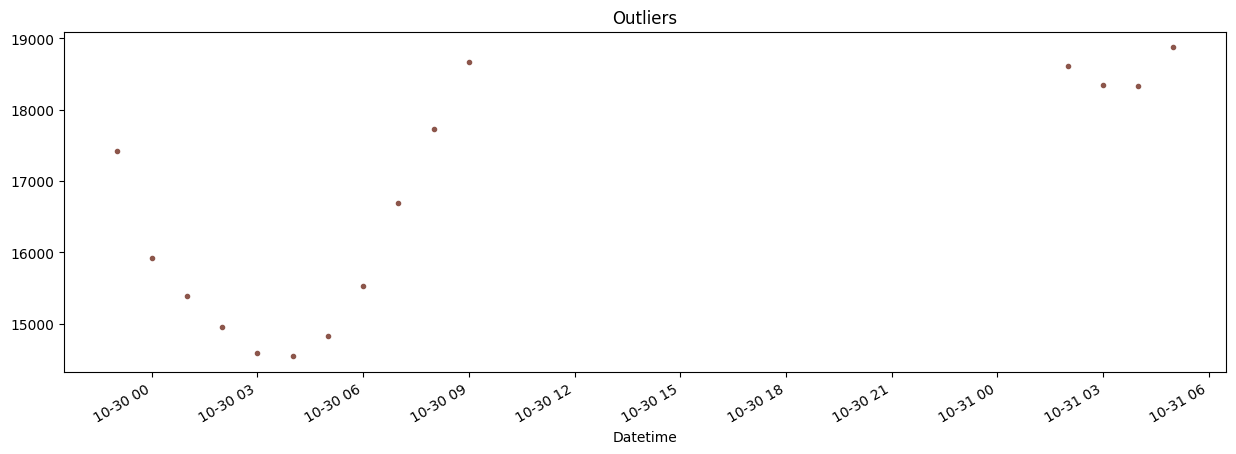

In [ ]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(15, 5), color=color_pal[5],title='Outliers');

In [ ]:
#df = df.query('PJME_MW > 19_000').copy()

Se genera un array de números aleatorios uniformemente distribuidos entre 19000 y 20000.

In [ ]:
condicion = df['PJME_MW'] < 19000
df.loc[condicion, 'PJME_MW'] = np.random.uniform(19000, 20000, condicion.sum())

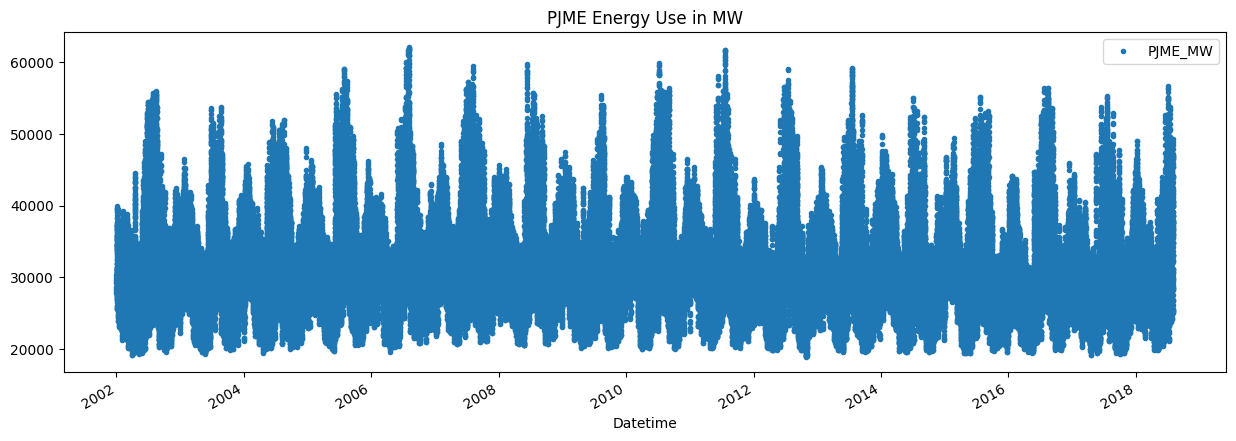

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

**Separación del dataset en train, test**

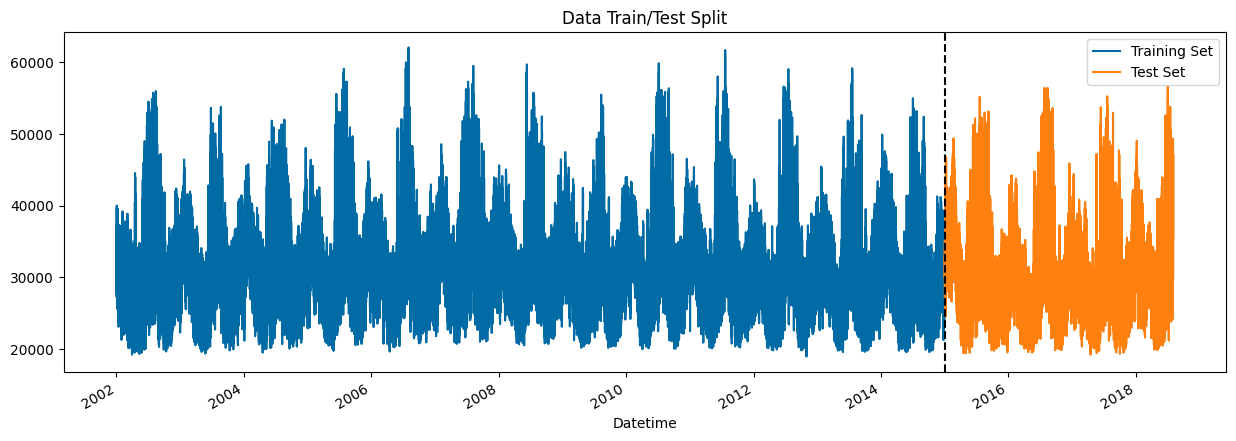

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Cross Validation para Series de Tiempo**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.

n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df = df.sort_index()

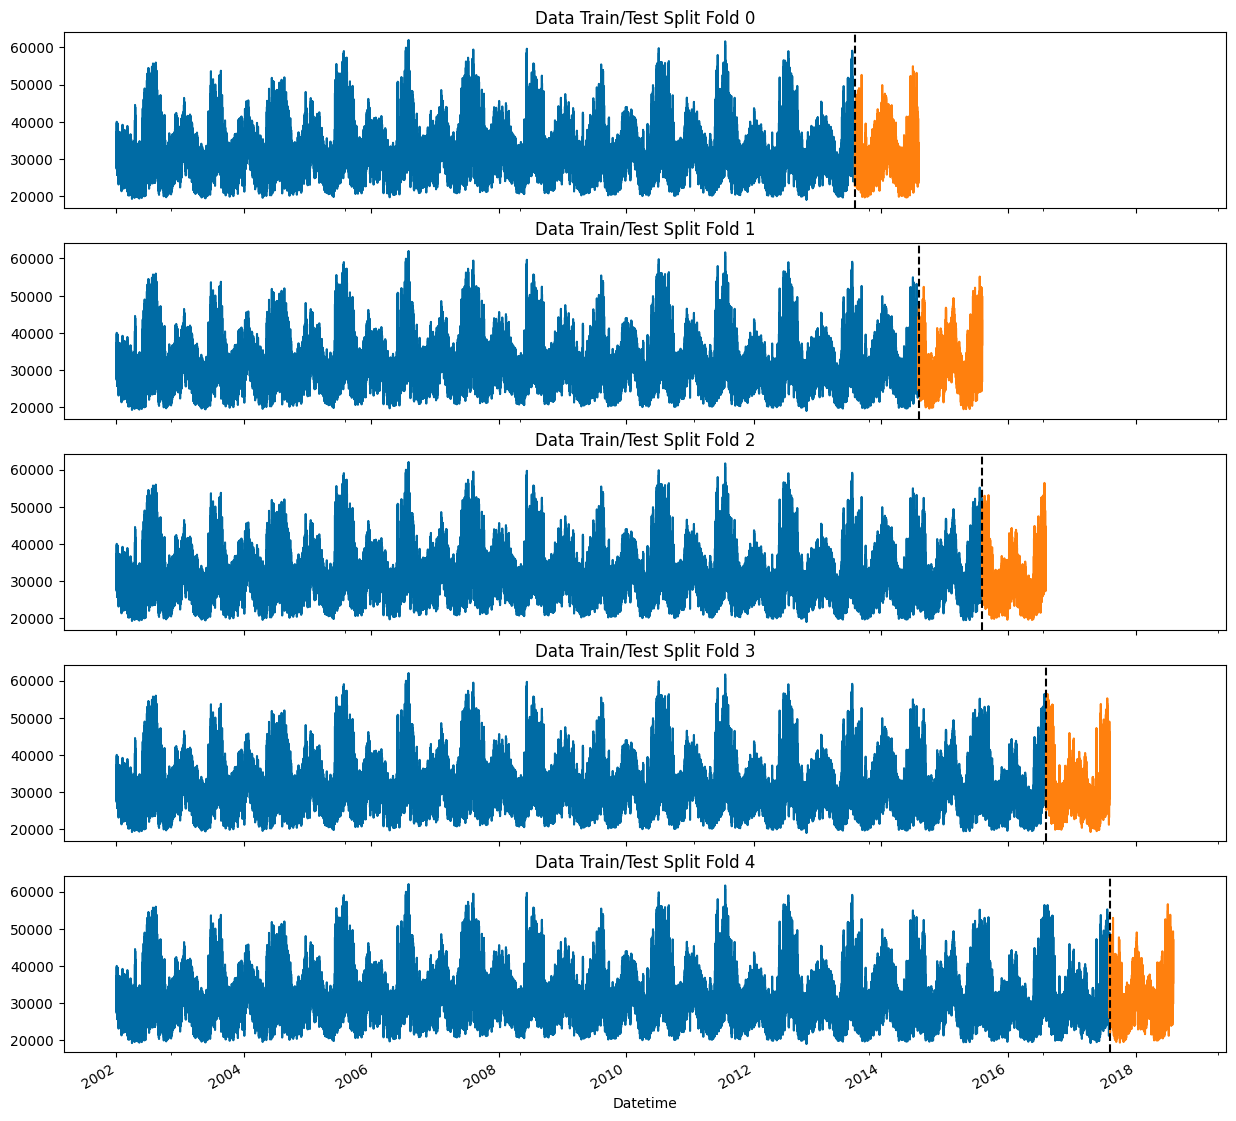

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['PJME_MW'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Visualizamos la estructura de tss

In [ ]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

In [ ]:
for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[     0      1      2 ... 101539 101540 101541]
  Test:  index=[101566 101567 101568 ... 110323 110324 110325]
Fold 1:
  Train: index=[     0      1      2 ... 110299 110300 110301]
  Test:  index=[110326 110327 110328 ... 119083 119084 119085]
Fold 2:
  Train: index=[     0      1      2 ... 119059 119060 119061]
  Test:  index=[119086 119087 119088 ... 127843 127844 127845]
Fold 3:
  Train: index=[     0      1      2 ... 127819 127820 127821]
  Test:  index=[127846 127847 127848 ... 136603 136604 136605]
Fold 4:
  Train: index=[     0      1      2 ... 136579 136580 136581]
  Test:  index=[136606 136607 136608 ... 145363 145364 145365]


**Feature Engineering**

In [ ]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df = create_features(df)

Agregamos rezagos de la variable target:

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


**Entrenamiento**

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    train = create_features(train)
    val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiendo como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['rmse', 'mae'],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6458.60436	validation_0-mae:4965.29761	validation_1-rmse:6142.83334	validation_1-mae:4949.44759


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:32:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4369.31619	validation_0-mae:3286.96262	validation_1-rmse:4103.20622	validation_1-mae:3336.50586
[200]	validation_0-rmse:3813.60907	validation_0-mae:2843.95565	validation_1-rmse:3764.88923	validation_1-mae:2980.66955
[300]	validation_0-rmse:3536.86830	validation_0-mae:2627.05712	validation_1-rmse:3717.98936	validation_1-mae:2864.41158
[400]	validation_0-rmse:3386.23849	validation_0-mae:2502.66821	validation_1-rmse:3748.47458	validation_1-mae:2844.61506
[500]	validation_0-rmse:3310.33380	validation_0-mae:2442.30569	validation_1-rmse:3771.75633	validation_1-mae:2841.15531
[600]	validation_0-rmse:3261.02739	validation_0-mae:2404.33717	validation_1-rmse:3790.43596	validation_1-mae:2844.68146
[700]	validation_0-rmse:3221.71677	validation_0-mae:2376.26036	validation_1-rmse:3797.40436	validation_1-mae:2845.23968
[800]	validation_0-rmse:3188.45642	validation_0-mae:2350.87641	validation_1-rmse:3797.78472	validation_1-mae:2841.60218
[900]	validation_0-rmse:3159.21775	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:32:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:6433.99176	validation_0-mae:4958.47433	validation_1-rmse:6250.15687	validation_1-mae:5085.96795
[100]	validation_0-rmse:4372.07472	validation_0-mae:3297.58789	validation_1-rmse:4158.98477	validation_1-mae:3341.18450
[200]	validation_0-rmse:3835.00704	validation_0-mae:2861.97091	validation_1-rmse:3698.50938	validation_1-mae:2875.90089
[300]	validation_0-rmse:3577.21035	validation_0-mae:2658.88329	validation_1-rmse:3557.01023	validation_1-mae:2709.40455
[400]	validation_0-rmse:3431.26595	validation_0-mae:2538.62145	validation_1-rmse:3516.96812	validation_1-mae:2644.43168
[500]	validation_0-rmse:3347.38660	validation_0-mae:2471.87642	validation_1-rmse:3497.96448	validation_1-mae:2600.24187
[600]	validation_0-rmse:3296.91686	validation_0-mae:2434.90673	validation_1-rmse:3477.13638	validation_1-mae:2566.32396
[700]	validation_0-rmse:3258.70829	validation_0-mae:2405.57319	validation_1-rmse:3460.45545	validation_1-mae:2541.01929
[800]	validation_0-rmse:3223.21836	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:32:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4367.71017	validation_0-mae:3302.83958	validation_1-rmse:4472.23594	validation_1-mae:3685.00924
[200]	validation_0-rmse:3832.97649	validation_0-mae:2862.63062	validation_1-rmse:3913.31629	validation_1-mae:3181.47902
[300]	validation_0-rmse:3591.10095	validation_0-mae:2668.59844	validation_1-rmse:3702.24627	validation_1-mae:2972.32721
[400]	validation_0-rmse:3448.16096	validation_0-mae:2550.54017	validation_1-rmse:3623.76631	validation_1-mae:2881.43458
[500]	validation_0-rmse:3372.84823	validation_0-mae:2489.89490	validation_1-rmse:3606.98140	validation_1-mae:2858.27194
[600]	validation_0-rmse:3319.45388	validation_0-mae:2450.26574	validation_1-rmse:3614.49795	validation_1-mae:2860.58251
[700]	validation_0-rmse:3278.25102	validation_0-mae:2419.80099	validation_1-rmse:3638.56401	validation_1-mae:2884.79689
[800]	validation_0-rmse:3243.98410	validation_0-mae:2392.89518	validation_1-rmse:3668.29509	validation_1-mae:2921.06368
[900]	validation_0-rmse:3218.16189	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:33:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4367.07699	validation_0-mae:3308.48289	validation_1-rmse:4641.67232	validation_1-mae:3664.91361
[200]	validation_0-rmse:3829.44271	validation_0-mae:2864.24924	validation_1-rmse:4275.51145	validation_1-mae:3289.58925
[300]	validation_0-rmse:3588.56401	validation_0-mae:2668.70007	validation_1-rmse:4179.59345	validation_1-mae:3154.97410
[400]	validation_0-rmse:3451.07354	validation_0-mae:2557.33635	validation_1-rmse:4130.39296	validation_1-mae:3061.57160
[500]	validation_0-rmse:3376.12284	validation_0-mae:2497.26059	validation_1-rmse:4095.51325	validation_1-mae:2983.80810
[600]	validation_0-rmse:3322.74956	validation_0-mae:2457.58859	validation_1-rmse:4095.54300	validation_1-mae:2962.17562
[700]	validation_0-rmse:3280.71102	validation_0-mae:2424.86751	validation_1-rmse:4086.20856	validation_1-mae:2942.20296
[800]	validation_0-rmse:3250.02591	validation_0-mae:2401.73259	validation_1-rmse:4082.96509	validation_1-mae:2933.43310
[900]	validation_0-rmse:3223.77460	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:33:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4388.89191	validation_0-mae:3329.08205	validation_1-rmse:4186.14595	validation_1-mae:3270.01254
[200]	validation_0-rmse:3861.14850	validation_0-mae:2892.35555	validation_1-rmse:3877.29989	validation_1-mae:2930.78563
[300]	validation_0-rmse:3629.91672	validation_0-mae:2701.88245	validation_1-rmse:3882.41245	validation_1-mae:2885.75506
[400]	validation_0-rmse:3495.29067	validation_0-mae:2590.87687	validation_1-rmse:3947.18447	validation_1-mae:2903.10334
[500]	validation_0-rmse:3422.55631	validation_0-mae:2528.48676	validation_1-rmse:4012.07723	validation_1-mae:2936.23578
[600]	validation_0-rmse:3374.32879	validation_0-mae:2490.75117	validation_1-rmse:4048.26793	validation_1-mae:2963.89032
[700]	validation_0-rmse:3337.56893	validation_0-mae:2462.96800	validation_1-rmse:4052.40989	validation_1-mae:2966.77829
[800]	validation_0-rmse:3307.00789	validation_0-mae:2439.18623	validation_1-rmse:4048.16196	validation_1-mae:2964.62460
[900]	validation_0-rmse:3277.99174	valid

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3802.3820
Fold scores:[3778.1912855574037, 3424.3209158100362, 3731.7182265289853, 4056.1325058853927, 4021.5472609342337]


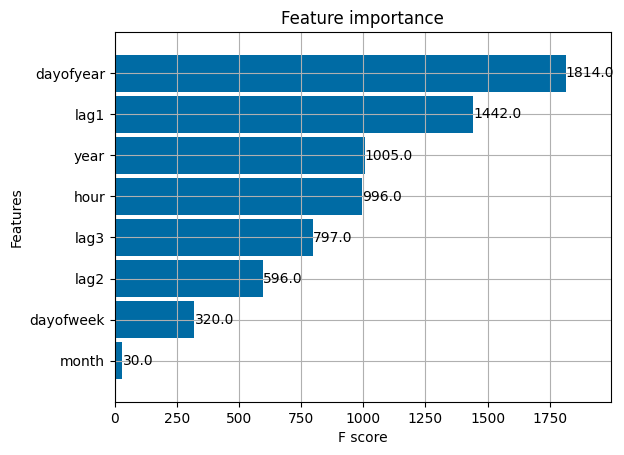

In [ ]:
_ = plot_importance(reg, height=0.9)

**Pronostico sobre los datos de Test**

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
y_pred

array([29280.646, 28257.773, 27467.535, ..., 39442.61 , 36610.508,
       31715.674], dtype=float32)

Adicionamos la predicción al set de Validación

In [ ]:
val['prediction'] = reg.predict(X_val)

In [ ]:
val['prediction']

Datetime
2017-08-03 01:00:00    29280.646484
2017-08-03 02:00:00    28257.773438
2017-08-03 03:00:00    27467.535156
2017-08-03 04:00:00    26776.849609
2017-08-03 05:00:00    26792.212891
                           ...     
2018-08-02 20:00:00    42519.976562
2018-08-02 21:00:00    41672.539062
2018-08-02 22:00:00    39442.609375
2018-08-02 23:00:00    36610.507812
2018-08-03 00:00:00    31715.673828
Name: prediction, Length: 8760, dtype: float32

In [ ]:
val

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,29280.646484
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,28257.773438
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,27467.535156
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,26776.849609
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,26792.212891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,42519.976562
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,41672.539062
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,39442.609375


**Visualización de la predicción y los datos originales:**

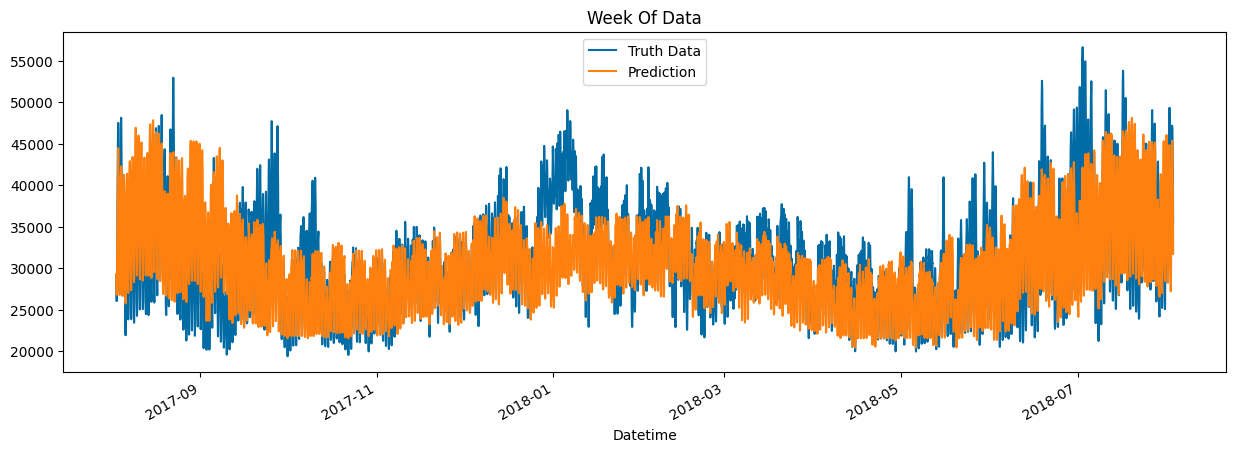

In [ ]:
ax = val.loc[(val.index >= '2017-08-03')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

**Métricas de performance:**

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 16172842.371927636
Mean Absolute Error (MAE): 2950.9010583886275
RMSE Score on Test set: 4021.55
